# Set up the Enviroment and check GPU

In [ ]:
!pip install PyDrive #get files from gdrive

In [ ]:
import os.path
import tensorflow as tf
import warnings
from distutils.version import LooseVersion
from google.colab import files
import shutil
import keras

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
# check keras version
print("Keras version: "+keras.__version__)

Default GPU Device: /device:GPU:0
Keras version: 2.4.3


# Connect to the data set by using Google Drive APIs

In [ ]:
from google.colab import files
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
import time

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
weights=drive.CreateFile({'id':'1uyOrTF7oxL2dyFQh9iQ81hIzPJlEl2KH'})
weights.GetContentFile('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [ ]:
dataset=drive.CreateFile({'id':'1v4CQv1Q3eag8xRwG1cgbcD-CXjzJHmXu'})
dataset.GetContentFile('data_road.zip')
zip_ref = zipfile.ZipFile("data_road.zip",'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
utils_file=drive.CreateFile({'id':'10YDp9U3I3r2XAMJD3IGedbthY0aZZ4de'})
utils_file.GetContentFile('ss_utils.py')
import ss_utils

# Load Data

In [ ]:
import os
import numpy as np
import cv2
import itertools
from glob import glob
import re
import random
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.layers import *
from keras import models
from keras import layers
from keras.utils import plot_model
from keras import optimizers
from keras.models import load_model
import matplotlib.pyplot as plt
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build
from keras import backend as K
from glob import glob

In [ ]:
base_dir='data_road'
train_dir = os.path.join(base_dir, 'training')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'testing')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
IMAGE_ORDERING = 'channels_first'
InputHeight=160
InputWidth=576
img_input = Input(shape=(InputHeight,InputWidth,3))
nClasses=2
drive_service = build('drive', 'v3')

In [ ]:
train_images,train_labels=ss_utils.get_data(train_dir, nClasses ,InputHeight, InputWidth)
val_images,val_labels=ss_utils.get_data(val_dir, nClasses, InputHeight, InputWidth)
train_Aug_lab,train_Aug_im=ss_utils.augment_training_data(train_images,train_labels,nClasses,InputHeight,InputWidth)
print('training samples: '+str(len(train_images)))
print('validation samples: '+str(len(val_images)))
print('training samples after augmentation: '+str(len(train_Aug_lab)))

training samples: 255
validation samples: 34
training samples after augmentation: 510


In [ ]:
def fcn32(n_Classes,topless_weights_path,input_height,input_width):
  img_input = Input(shape=(input_height,input_width,3))
  
  x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1',kernel_initializer='he_normal')(img_input)
  x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2',kernel_initializer='he_normal')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
  
  # Block 2
  x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1',kernel_initializer='he_normal')(x)
  x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2',kernel_initializer='he_normal')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
  
  # Block 3
  x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1',kernel_initializer='he_normal')(x)
  x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2',kernel_initializer='he_normal')(x)
  x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3',kernel_initializer='he_normal')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
  
  # Block 4
  x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1',kernel_initializer='he_normal')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2',kernel_initializer='he_normal')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3',kernel_initializer='he_normal')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
  
  # Block 5
  x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1',kernel_initializer='he_normal')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2',kernel_initializer='he_normal')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3',kernel_initializer='he_normal')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
  
  vgg  = Model(img_input , x)
  vgg.load_weights(topless_weights_path)
  
  x = (Conv2D(4096 , (7 , 7 ) , activation='relu' , padding='same',kernel_initializer='he_normal',name="conv6"))(x)
  x = Dropout(0.5)(x)
  x = (Conv2D(4096 , (1 , 1 ) , activation='relu' , padding='same',kernel_initializer='he_normal',name="conv7"))(x)
  x = Dropout(0.5)(x)
  
  x = (Conv2D(n_Classes ,  ( 1 , 1 ),padding='same' ,kernel_initializer='he_normal',name="scorer1"))(x)
  x = Conv2DTranspose(n_Classes , kernel_size=(64,64) ,padding='same',  strides=(32,32),name="Upsample32")(x)
  
  o_shape = Model(img_input,x).output_shape
  output_Height = o_shape[1]
  output_Width = o_shape[2]
  
  x = (Reshape((-1  , output_Height*output_Width)))(x)
  x = (Permute((2, 1)))(x)
  x = (Activation('softmax'))(x)
  
  model = Model( img_input , x)
  model.outputWidth = output_Width
  model.outputHeight = output_Height
  for l in vgg.layers:
    if "input" not in l.name:
      w=l.get_weights()
      model.get_layer(l.name).set_weights(w)
      model.get_layer(l.name).trainable=False
    
  return  model


In [ ]:
fcn32model=ss_utils.fcn32(nClasses,'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',InputHeight,InputWidth)
fcn32model.summary()
fcn32model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=1e-4),metrics=['acc'])

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 576, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 576, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 576, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 288, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 288, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 288, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 144, 128)     

In [ ]:
history = fcn32model.fit(x=train_Aug_im, y=train_Aug_lab,
                    epochs=20,
                    batch_size=10,
                    validation_data=(val_images, val_labels))

Epoch 1/20
51/51 [==============================] - 20s 396ms/step - loss: 0.5461 - acc: 0.6852 - val_loss: 0.3284 - val_acc: 0.8488
Epoch 2/20
51/51 [==============================] - 20s 388ms/step - loss: 0.2399 - acc: 0.8930 - val_loss: 0.1971 - val_acc: 0.9128
Epoch 3/20
51/51 [==============================] - 19s 379ms/step - loss: 0.1721 - acc: 0.9251 - val_loss: 0.1818 - val_acc: 0.9198
Epoch 4/20
51/51 [==============================] - 19s 378ms/step - loss: 0.1472 - acc: 0.9362 - val_loss: 0.1722 - val_acc: 0.9246
Epoch 5/20
51/51 [==============================] - 19s 379ms/step - loss: 0.1335 - acc: 0.9424 - val_loss: 0.1677 - val_acc: 0.9269
Epoch 6/20
51/51 [==============================] - 19s 382ms/step - loss: 0.1233 - acc: 0.9469 - val_loss: 0.1644 - val_acc: 0.9305
Epoch 7/20
51/51 [==============================] - 19s 382ms/step - loss: 0.1133 - acc: 0.9513 - val_loss: 0.1715 - val_acc: 0.9296
Epoch 8/20
51/51 [==============================] - 19s 380ms/step - 

# Plot out the training and validation accuracy and loss



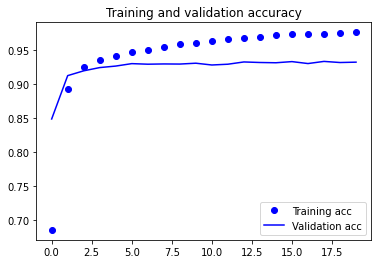

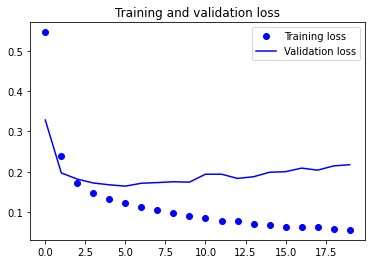

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
fcn32model.save('fcn32.h5')
ss_utils.save_file_to_drive(drive_service,"fcn32.h5", "fcn32.h5")

File ID: 1U_9XmhgCYSzBwYBnHklPKJ2tHnxCkJNT


{'id': '1U_9XmhgCYSzBwYBnHklPKJ2tHnxCkJNT'}

In [ ]:
fcn32= load_model('fcn32.h5')

In [ ]:
print(fcn32)

In [ ]:
def getfcn8(fcnmodel,n_classes):
  x=fcnmodel.get_layer('scorer1').output
#   x=Conv2DTranspose(n_classes, kernel_size=(4,4), strides=(2,2), use_bias=False)(x)
  x=Conv2DTranspose(n_classes, kernel_size=(4,4),kernel_initializer='he_normal',padding='same', strides=(2,2),name="deconv1")(x)
  
  l4 = fcnmodel.get_layer('block4_pool').output
  l4= (Conv2D(n_classes, (1 , 1 ),padding='same',kernel_initializer='he_normal',name="scorer2"))(l4)
  x,l4 = crop(x, l4 , fcnmodel.input)
  x=Add()([l4,x])
#   x = Conv2DTranspose(n_classes, kernel_size=(4,4), strides=(2,2), use_bias=False)(x)
  x = Conv2DTranspose(n_classes, kernel_size=(4,4),kernel_initializer='he_normal',padding='same', strides=(2,2),name="deconv2")(x)

  l3 = fcnmodel.get_layer('block3_pool').output
  l3 = (Conv2D(n_classes ,  ( 1 , 1 ) ,padding='same',kernel_initializer='he_normal',name="scorer3"))(l3)
  l3,x = crop(l3,x, fcnmodel.input)
  x  = Add()([l3,x])
#   x = Conv2DTranspose(n_classes , kernel_size=(16,16) ,  strides=(8,8) , use_bias=False)(x)
  x = Conv2DTranspose(n_classes,padding='same',kernel_initializer='he_normal' , kernel_size=(16,16) ,strides=(8,8),name="Upsample8")(x)
  
  o_shape = Model(fcnmodel.inputs , x).output_shape
  oH = o_shape[1]
  oW = o_shape[2]
  x = (Reshape((-1  , oH*oW)))(x)
  x = (Permute((2, 1)))(x)
  x = (Activation('softmax'))(x)
  M = Model(fcnmodel.input, x)	
  for l in M.layers:
    l.trainable=True
  M.outputWidth = oW
  M.outputHeight = oH
  return M

In [ ]:
def crop(a,b,input_image):
  
  o_shape1 = Model(input_image, a ).output_shape
  outputHeight1 = o_shape1[1]
  outputWidth1 = o_shape1[2]

  o_shape2 = Model(input_image , b).output_shape
  outputHeight2 = o_shape2[1]
  outputWidth2 = o_shape2[2]
    
  cx = abs( outputWidth1 - outputWidth2 )
  cy = abs( outputHeight2 - outputHeight1 )
  
  if outputWidth1 > outputWidth2:
    a = Cropping2D(cropping=((0,0) , ( 0 , cx )))(a)
  else:
    b = Cropping2D(cropping=((0,0) , ( 0 , cx )))(b)
    
  if outputHeight1 > outputHeight2 :
    a = Cropping2D(cropping=((0,cy) , ( 0 , 0 )))(a)
  else:
    b = Cropping2D(cropping=((0, cy ) , ( 0 , 0)))(b)
  return a , b

In [ ]:

fcn8model=getfcn8(fcn32model,nClasses)
fcn8model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=1e-4),metrics=['acc'])
plot_model(fcn8model)
fcn8model.summary()

Model: "functional_107"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 576, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 160, 576, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 160, 576, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 80, 288, 64)  0           block1_conv2[0][0]               
_____________________________________________________________________________________

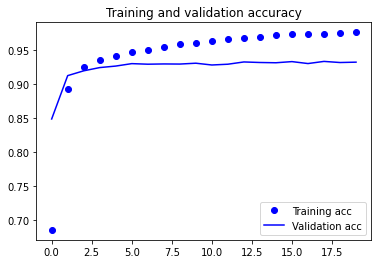

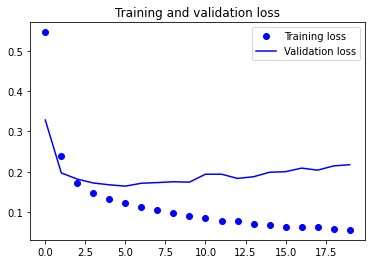

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
fcn8model.save('fcn8.h5')
ss_utils.save_file_to_drive(drive_service,"fcn8.h5", "fcn8.h5")

File ID: 1sAGn_DtKuNJYjXFp9tac102BrwMaodC6


{'id': '1sAGn_DtKuNJYjXFp9tac102BrwMaodC6'}

Read model and plot out the result

In [ ]:
fcn8model=load_model('fcn8.h5')

In [ ]:
fcn32model=load_model('fcn32.h5')

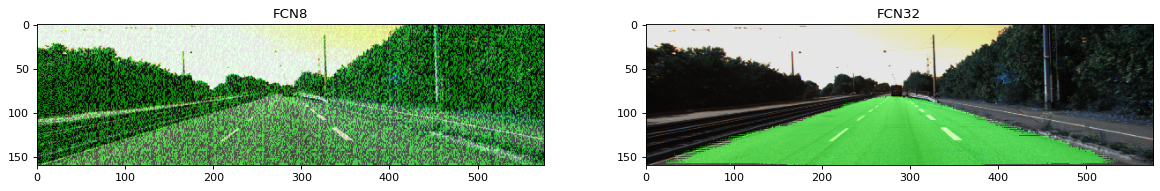

<Figure size 432x288 with 0 Axes>

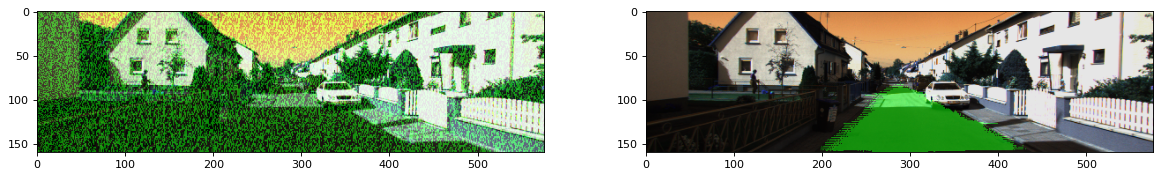

<Figure size 432x288 with 0 Axes>

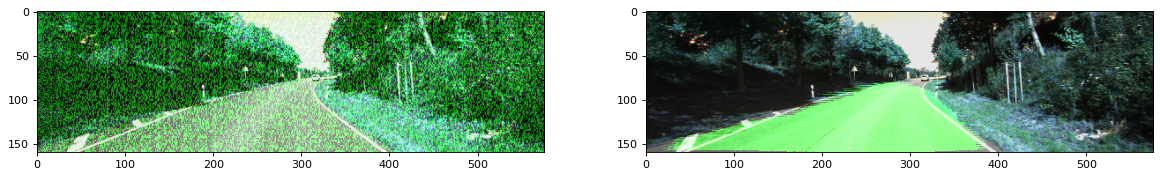

In [ ]:
%matplotlib inline
plt.rcParams["axes.grid"] = False

image_paths = glob(os.path.join('data_road/training/', 'image_2', '*.png'))
nImages=3
idx=np.random.choice(len(image_paths),size=nImages)
for i,id in enumerate(idx):
  imgName=image_paths[id]
  outName = os.path.join('predictions',os.path.basename(imgName))
  im0 = cv2.imread(imgName, 1)
  im,seg_img=ss_utils.fcn_predict(fcn8model,im0,nClasses,InputHeight,InputWidth)
  fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
  if i==0: plt.subplot(1, 2, 1).set_title('FCN8')
  else: plt.subplot(1, 2, 1)
  plt.imshow(cv2.addWeighted(im,0.9,seg_img,0.5,0))
  if i==0: plt.subplot(1, 2, 2).set_title('FCN32')
  else: plt.subplot(1, 2, 2)
  im,seg_img2=ss_utils.fcn_predict(fcn32model,im0,nClasses,InputHeight,InputWidth)
  plt.imshow(cv2.addWeighted(im,0.9,seg_img2,0.5,0))
  if i==(len(idx)-1): plt.show()
  else: plt.figure()